# OBJVAE

## Init

In [1]:
import os
import random, os
import numpy as np
import torch
import importlib
from objVAE import objVAE, MultiheadAttention


os.environ["CUDA_VISIBLE_DEVICES"] = "1"


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

### Helper functions

In [2]:
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

image_size = 64

def run_test_old(model, combine_radius, plot_num=0, num_entities=10):
    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):
        gt_nodes = test_centroids[i_seq]

        # x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        x_hat, indices, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        x_hat = x_hat.detach().cpu().numpy()

        #n = [i for i_frame in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(mu.shape[0]):
            xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()

            flatind = indices[i, :].detach().cpu().numpy()

            mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]

            xy = xy_mu[:, flatind]

            row, col = np.unravel_index(flatind, (16, 16))
            xp = (row + 0.5) * 4 - xy[0, :] * 2
            yp = (col + 0.5) * 4 - xy[1, :] * 2

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(mu.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                plt.subplot(1, 2, 2)
                plt.imshow(x_hat[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i] * 1000
            yp_filtred = yp + remove_map_v[i] * 1000

            distances = distance_matrix(
                np.array([xp_filtred / image_size, yp_filtred / image_size]),
                gt_nodes_timestep,
            )
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                last_mapping = min_distance
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            tp = np.sum(gt_attention.astype(bool) & binary_attention.astype(bool))
            fp = np.sum(binary_attention.astype(bool)) - tp
            tn = np.sum(
                ~gt_attention.astype(bool) & ~binary_attention.astype(bool)
            )
            fn = np.sum(~binary_attention.astype(bool)) - tn

            mse_total.append(mse)
            false_detections_total.append(
                false_detections / (false_detections + true_detections)
            )
            missed_detections_total.append(missed_detections / (min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.argmax(binary_attention, axis=1)
                for i_prev, i_curr in enumerate(cols):
                    if remove_map_v[i - 1][i_prev] or remove_map_v[i][i_curr]:
                        continue
                    x_line = [xp_v[i - 1][i_prev], xp_v[i][i_curr]]
                    y_line = [yp_v[i - 1][i_prev], yp_v[i][i_curr]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean / (tp_mean + fp_mean)
    recall = tp_mean / (tp_mean + fn_mean)

    f1 = 2 * precision * recall / (precision + recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }

def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        #new_attention_row = attention_to_next_dt
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def run_test(model, combine_radius, plot_num=0, num_entities=10, pres_floor=0.25, tra_floor=0.25):
    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):
        gt_nodes = test_centroids[i_seq]

        # x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        recon, indices, pres, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        recon = recon.detach().cpu().numpy()
        pres = pres.detach().cpu().numpy()
        xy = xy.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(xy.shape[0]):

            xp = xy[i, :, 0]
            yp = xy[i, :, 1]

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            pres_mask = pres[i] <= pres_floor

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0) + pres_mask

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(xy.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                    for ann in annotations:
                        ann.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                annotations = []
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    annotations.append(
                        plt.annotate(
                            round(pres[i, j], 3), (yp[j], xp[j]), color="white"
                        )
                    )
                plt.subplot(1, 2, 2)
                plt.imshow(recon[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i] * 1000
            yp_filtred = yp + remove_map_v[i] * 1000

            distances = distance_matrix(
                np.array([xp_filtred / image_size, yp_filtred / image_size]),
                gt_nodes_timestep,
            )
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                last_mapping = min_distance
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )

            if i_seq == plot_num:
                print(new_attention)

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            #binary_attention = np.where(new_attention >= tra_floor, 1, 0)

            tp = np.sum(gt_attention.astype(bool) & binary_attention.astype(bool))
            fp = np.sum(binary_attention.astype(bool)) - tp
            tn = np.sum(
                ~gt_attention.astype(bool) & ~binary_attention.astype(bool)
            )
            fn = np.sum(~binary_attention.astype(bool)) - tn

            mse_total.append(mse)
            if (false_detections + true_detections):
                false_detections_total.append(
                    false_detections / (false_detections + true_detections)
                )
            missed_detections_total.append(missed_detections / (min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.where(binary_attention == 1)
                #cols = np.argmax(binary_attention, axis=1)
                for i_col, _ in enumerate(cols[0]):
                    previous = cols[0][i_col]
                    current = cols[1][i_col]
                    if remove_map_v[i - 1][previous] or remove_map_v[i][current]:
                        continue
                    x_line = [xp_v[i - 1][previous], xp_v[i][current]]
                    y_line = [yp_v[i - 1][previous], yp_v[i][current]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean / (tp_mean + fp_mean)
    recall = tp_mean / (tp_mean + fn_mean)

    f1 = 2 * precision * recall / (precision + recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }
def update_position(previous_value, diffusion_constant, dt=1 / 10):
    new_position = np.clip(
        previous_value + np.random.randn(2) * np.sqrt(diffusion_constant * dt) * 1e7,
        0,
        image_size,
    )
    return new_position


def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions) / image_size


def generate_data(sequence_length, data_amount=1000):
    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6 / 2, 1e-6 * 2),
        z=lambda: np.random.uniform(-2, 2) * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    # %%
    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2, 6))
    image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    image_pipeline.update().plot()

    # generate a dataset of 1000 images
    print("Generating Training data")
    images = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)
        images.append(image_pipeline.update()())

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)
    print(tensors.shape)
    # make channel first
    tensors = tensors.permute(0, 1, 4, 2, 3)
    train_set, test_set = torch.utils.data.random_split(
        tensors, [int(data_amount * 0.8), int(data_amount * 0.2)]
    )

    test, test_centroids, test_edges = generate_test_data(int(data_amount*0.1), sequence_length)

    return train_set, test_set, test, test_centroids, test_edges

def generate_test_data(data_amount, sequence_length, noise_mu=0, noise_sigma=0.1):
    print("Generating Test data")

    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6 / 2, 1e-6 * 2),
        z=lambda: np.random.uniform(-2, 2) * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2,8))
    image_pipeline = optics(particles) >> dt.Gaussian(mu=noise_mu, sigma=noise_sigma)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)

        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)

            if i == len(images):
                break

            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)

        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return test, test_centroids, test_edges


def make_dataloaders(train_set, test_set, batch_size=16, num_workers=0):
    # create dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,  num_workers=num_workers)
    return train_loader, test_loader


def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        recon, indices, pres, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        alpha = pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(pres[0, alpha].detach().cpu().numpy())

    else:
        recon, indices, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    if trainer:
        if trainer.current_epoch % 100 == 0:
            plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

2023-10-02 06:22:15.115306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 06:22:16.584296: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstr

In [3]:
def _combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        #new_attention_row = attention_to_next_dt
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def _distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def extract_obj_and_tra(model, sequence, combine_radius=4, num_entities=10):

    sequence = torch.unsqueeze(sequence, dim=0)
    sequence = sequence.to(model.device)
    recon, indices, pres, kl_divergence, xy_pred, mu, logvar, attention, xy = model(sequence)

    #x = x.detach().cpu().numpy()
    recon = recon.detach().cpu().numpy()
    pres = pres.detach().cpu().numpy()
    xy = xy.detach().cpu().numpy()

    combine_map_v = []
    remove_map_v = []
    xp_v = []
    yp_v = []
    for i in range(xy.shape[0]):

        xp = xy[i, :, 0]
        yp = xy[i, :, 1]

        xp_v.append(xp)
        yp_v.append(yp)

        distances = []
        for j in range(xp.shape[0]):
            distance_r = []
            for k in range(xp.shape[0]):
                if j == k:
                    distance_r.append(0)
                    continue
                dist = _distance(xp[j], xp[k], yp[j], yp[k])
                distance_r.append(dist)
            distances.append(distance_r)
        distances = np.array(distances)

        # Create the combin map
        row_indices, col_indices = np.indices(distances.shape)
        matrix = np.zeros(distances.shape)
        matrix[row_indices - col_indices <= 0] = 1

        combine_map = (
            np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
            & matrix.astype(bool)
        ).astype(np.int32)

        pres_mask = pres[i] <= 0.25

        remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0) + pres_mask

        combine_map_v.append(combine_map)
        remove_map_v.append(remove_map)

    tra_dict_new = {}
    final_tra_list = []
    for i_frame, frame in enumerate(xy):
        tra_dict = tra_dict_new.copy()

        if i_frame == 0:
            for i_obj, obj in enumerate(frame):
                if not remove_map_v[i_frame][i_obj]:
                    tra_dict_new[i_obj] = _new_obj_dict(obj, i_frame)
            continue

        # Calculate attention metrics
        binary_attention = _get_connections(attention, i_frame, num_entities, combine_map_v, remove_map_v)
        binary_attention_t = np.transpose(binary_attention)

        visited = set()
        added = set()
        for i_obj, obj in enumerate(frame):
            connections = np.where(binary_attention_t[i_obj] == 1)[0]
            if remove_map_v[i_frame][i_obj] or not connections.size > 0:
                continue
            obj_dict = tra_dict.get(connections[0])
            if obj_dict:
                obj_dict['x'].append(obj[0])
                obj_dict['y'].append(obj[1])
                obj_dict['code'].append(-1)
                if not connections[0] in added:
                    del tra_dict_new[connections[0]]
                tra_dict_new[i_obj] = obj_dict
                visited.add(connections[0])
                added.add(i_obj)
            else:
                tra_dict_new[i_obj] = _new_obj_dict(obj, i_frame)


        ended = tra_dict.keys() - visited
        for end in ended:
            obj_dict = tra_dict.pop(end)
            obj_dict['end'] = i_frame - 1
            del(tra_dict_new[end])
            final_tra_list.append(obj_dict)
    
    obj_dicts = list(tra_dict_new.values())
    final_tra_list.extend(obj_dicts)
    return final_tra_list

def _new_obj_dict(obj, frame):
    return {'x':[obj[0]], 'y':[obj[1]], 'code':[-1], 'start':frame}

def _get_connections(attention, i_frame, num_entities, combine_map, remove_map):
    attention_to_next = attention[
        0,
        (i_frame - 1) * num_entities : i_frame * num_entities,
        i_frame * num_entities : (i_frame + 1) * num_entities,
    ]
    new_attention = _combine_nodes(
        attention_to_next, combine_map, remove_map, i_frame - 1
    )

    max_indices = np.argmax(new_attention, axis=1)
    binary_attention = np.zeros_like(new_attention)
    binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
    binary_attention *= np.where(new_attention > 0, 1, 0)

    return binary_attention


    

## Run/Test

### Generate data

Generating Training data
0
torch.Size([100, 5, 64, 64, 1])
Generating Test data
0


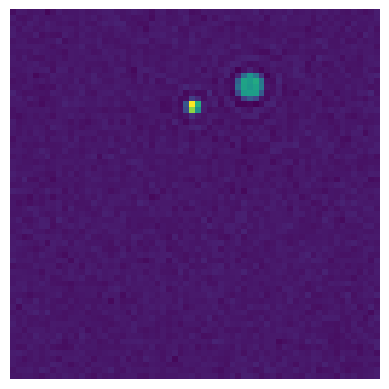

In [4]:
seqeunce_length = 5
data_amount = 100
batch_size = 16

train_set, test_set, test, test_centroids, test_edges = generate_data(
    sequence_length=seqeunce_length,
    data_amount=data_amount,
)

In [5]:
num_workers = 0

train_loader, test_loader = make_dataloaders(train_set, test_set, batch_size=batch_size, num_workers=num_workers)

### Create model

In [6]:
import IPython.display as ipd

# Callbacks
max_steps = 20000
beta_annealing_end = 1800
lr_annealing_end = max_steps
kl_annealing_end = 2400
presence_annealing_end = 2500

def beta_annealing(step):
    logs = np.logspace(-8.3, -7, beta_annealing_end)
    if step >= beta_annealing_end:
        return logs[-1]
    else:
        return logs[int(step)]


def presence_annealing(step):
    lins = np.linspace(0, 1, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)

class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [19]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

load_model = ""

#load_model = "../state_dicts/model-5-500-spatial-non.pth"
load_model = "../state_dicts/model-5-20000-presW-glim64-an.pth"


use_attention = True
num_entities = 100
softmax_tmp = 10
# beta = 1e-9
beta = 0
number_of_heads = 1
use_old = False
object_radius = 64
combine_method = "max"
single_decoder = True
attention_mechanism='cosine-similarity'


attention = MultiheadAttention.MultiheadAttention(
    max_t=1, attention_mechanism=attention_mechanism, softmax_factor=softmax_tmp, number_of_heads=1, num_filters=13
)
model = objVAE.MEVAE(
    10,
    attention_model=attention,
    beta=beta,
    attention=use_attention,
    object_radius=object_radius,
    use_old=use_old,
    combine_method=combine_method,
    single_decoder = single_decoder
)


if load_model:
    model.load_state_dict(torch.load(load_model))


### Train

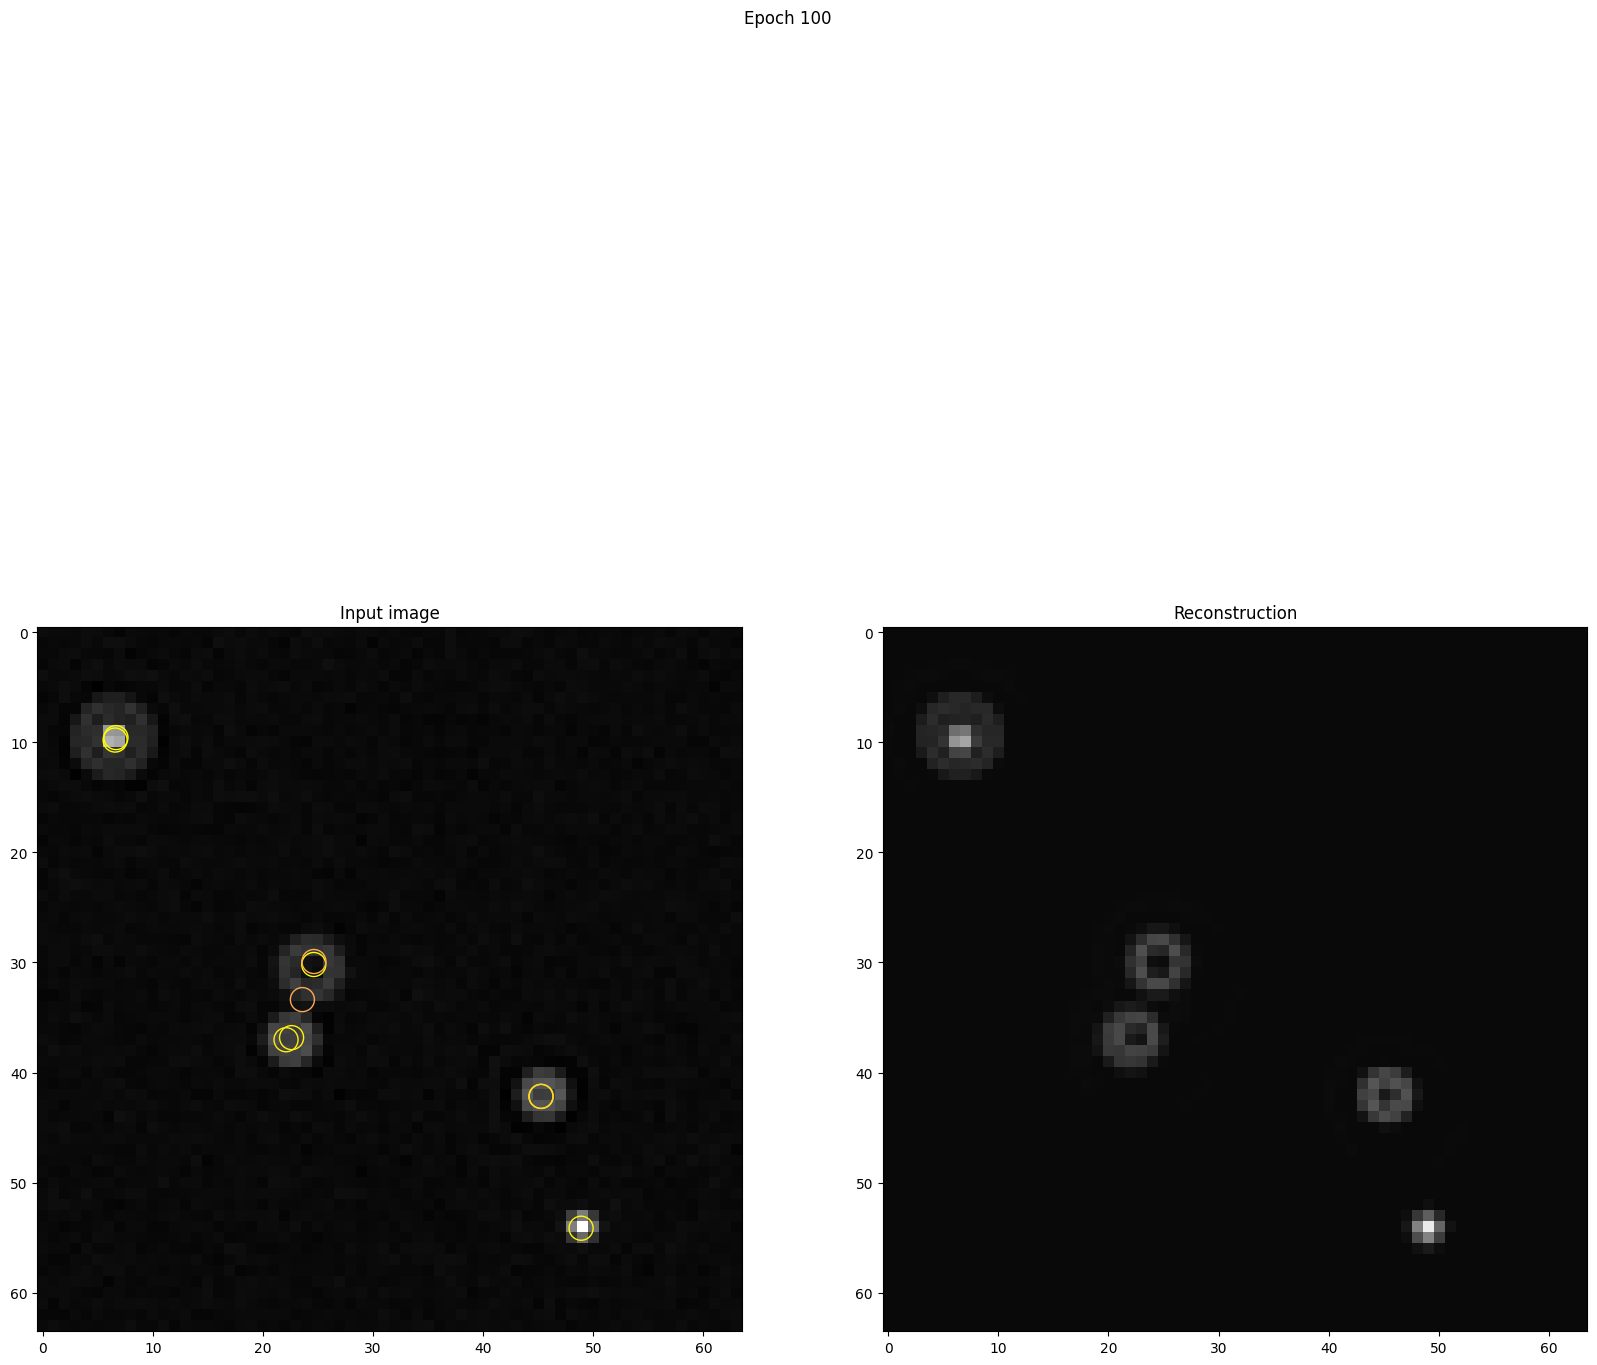

Epoch 101:  60%|██████    | 3/5 [00:00<00:00,  4.76it/s, v_num=1272, loss_step=0.0135, reconstruction_loss_step=0.0133, KLD_step=465.0, weighted_KLD_step=0.000144, loss_epoch=0.0147, reconstruction_loss_epoch=0.0145, KLD_epoch=482.0, weighted_KLD_epoch=0.000148]

In [49]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

### Test

In [9]:
test, test_centroids, test_edges = generate_test_data(100, 15, noise_mu=0, noise_sigma=0)

Generating Test data
0


...........
{'x': [22.899944], 'y': [24.083488], 'code': [-1], 'start': 0, 'end': 0}
{'x': [19.914766, 18.07348, 19.663544], 'y': [51.78969, 52.870644, 53.219795], 'code': [-1, -1, -1], 'start': 0, 'end': 2}
{'x': [42.939144], 'y': [44.659916], 'code': [-1], 'start': 3, 'end': 3}
{'x': [5.758555, 6.6448784, 7.698107, 11.516375], 'y': [51.029144, 52.46788, 50.01366, 51.154827], 'code': [-1, -1, -1, -1], 'start': 0, 'end': 3}
{'x': [24.167757, 26.061432, 25.193958], 'y': [17.184029, 19.55852, 22.30802], 'code': [-1, -1, -1], 'start': 6, 'end': 8}
{'x': [17.960844, 14.327969, 14.410779, 17.229559, 19.108553], 'y': [34.33018, 33.454876, 31.531025, 31.879684, 32.917107], 'code': [-1, -1, -1, -1, -1], 'start': 4, 'end': 8}
{'x': [45.51479, 44.9414, 42.036552, 41.999676, 25.005573], 'y': [42.793015, 42.57538, 40.46586, 38.791264, 21.009369], 'code': [-1, -1, -1, -1, -1], 'start': 5, 'end': 9}
{'x': [47.19627, 48.875957, 46.619514, 49.39658, 46.711086, 48.756123, 46.789394, 46.830933, 48.57305

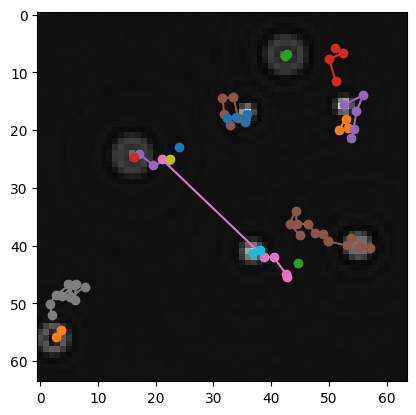

In [58]:
seq = test[33]

tra_list = extract_obj_and_tra(model, seq, 4, num_entities=10)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

[[0.15454836 0.         0.04367162 0.10356002 0.         0.
  0.         0.         0.         0.        ]
 [0.03885933 0.         0.15115683 0.11996767 0.         0.
  0.         0.         0.         0.        ]
 [0.05881818 0.         0.12644218 0.12947926 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

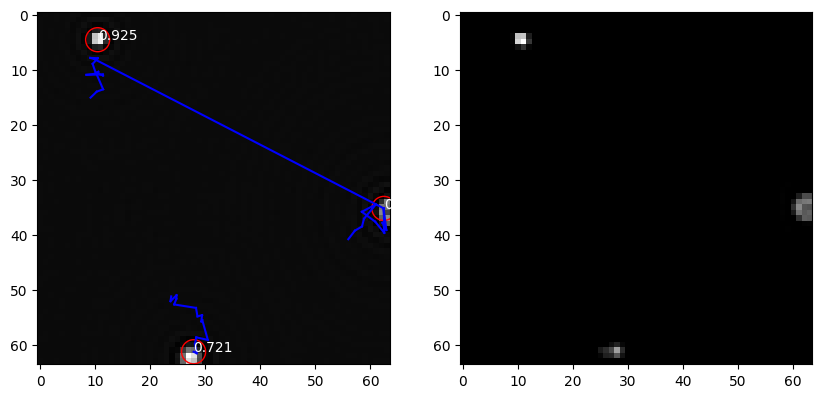

In [48]:
metrics = run_test(model, 4, num_entities=10, plot_num=21, pres_floor=0.25, tra_floor=0.2)
#metrics = run_test_old(model, 3, num_entities=10, plot_num=10)

print(metrics)

### Save model

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-5-20000-presW-glim64-an.pth")